# House price prediction

The purpose of this project is to construct models to predict sales prices for houses using Machine Learning regression techniques.  

We selected the Ames Housing dataset, made available by [Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques).  

The dataset contains 1460 complete samples with 80 attributes that vary from overal quality to garage conditions. A complete description of all attributes can be found in the data_description.txt file.  


## 1. Preprocessing

We begin by loading and preprocessing the data. In the pre processing step, we transform the raw data into useful inputs, checking for duplicates and missing values. A new column for price per square feet is also created to be used as a target varible. The transfomed data is ready to be loaded to a database and to be used for various visualization techniques and other applications. 

### 1.1. Load data and check for duplicates, missing values and correct data types


In [204]:
#import all the libraries used in this projects
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew
from scipy import stats

from matplotlib import pyplot as plt
%matplotlib inline
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.model_selection import train_test_split

The data loaded has the following data types: float64(3 columns), int64(35 columns), object(43 columns) with a total of 81 columns.

In [205]:
df= pd.read_csv('train.csv')
df.columns = df.columns.str.lower() 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

There are a total of 19 columns with null values in the data set. No duplicates were found.

In [206]:
if df.duplicated().any()== False:
    print("No duplicate values.")
else:
    print("There are duplicated values.")

col_isnull_any= []
for column in df.columns:
    if df[column].isnull().any():
        col_isnull_any.append(column)
print(f'Number of null columns: {len(col_isnull_any)}')
print(f'Columns with null values: {col_isnull_any}')


No duplicate values.
Number of null columns: 19
Columns with null values: ['lotfrontage', 'alley', 'masvnrtype', 'masvnrarea', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'electrical', 'fireplacequ', 'garagetype', 'garageyrblt', 'garagefinish', 'garagequal', 'garagecond', 'poolqc', 'fence', 'miscfeature']


We create list for different groups of features for different data types with the following criteria:
* categorical columns = columns with non numerical data types and numerical data types with unique values less or equal to 16.  
* numerical data types = columns with numerical data types and that are not in the categorical column.
* cardinal data types = categorical data types with more than 20 unique values

In [207]:
#create categories
cat_thier=16
car_thier=20
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
num_but_cat = [col for col in df.columns if df[col].nunique() <= cat_thier and
                   df[col].dtypes != "O"]
cat_but_car = [col for col in df.columns if df[col].nunique() > car_thier and
                   df[col].dtypes == "O"]
cat_cols = cat_cols + num_but_cat
cat_cols = [col for col in cat_cols if col not in cat_but_car]

# count and list the created groups.
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
num_cols = [col for col in num_cols if col not in num_but_cat]

print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f'cat_cols: {len(cat_cols)}')
print(f'num_cols: {len(num_cols)}')
print(f'cat_but_car: {len(cat_but_car)}')
print(f'num_but_cat: {len(num_but_cat)}')
    
print(f"""Categorical Variables={cat_cols},\nNumerical Variables={num_cols},\nNumerical but categorical={num_but_cat},\nCategorical but Cardinal Variables={cat_but_car}""")

Observations: 1460
Variables: 81
cat_cols: 57
num_cols: 23
cat_but_car: 1
num_but_cat: 15
Categorical Variables=['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition', 'mssubclass', 'overallqual', 'overallcond', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'poolarea', 'mosold', 'yrsold'],
Numerical Variables=['id', 'lotfrontage', 'lotarea', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmt

<function matplotlib.pyplot.show(close=None, block=None)>

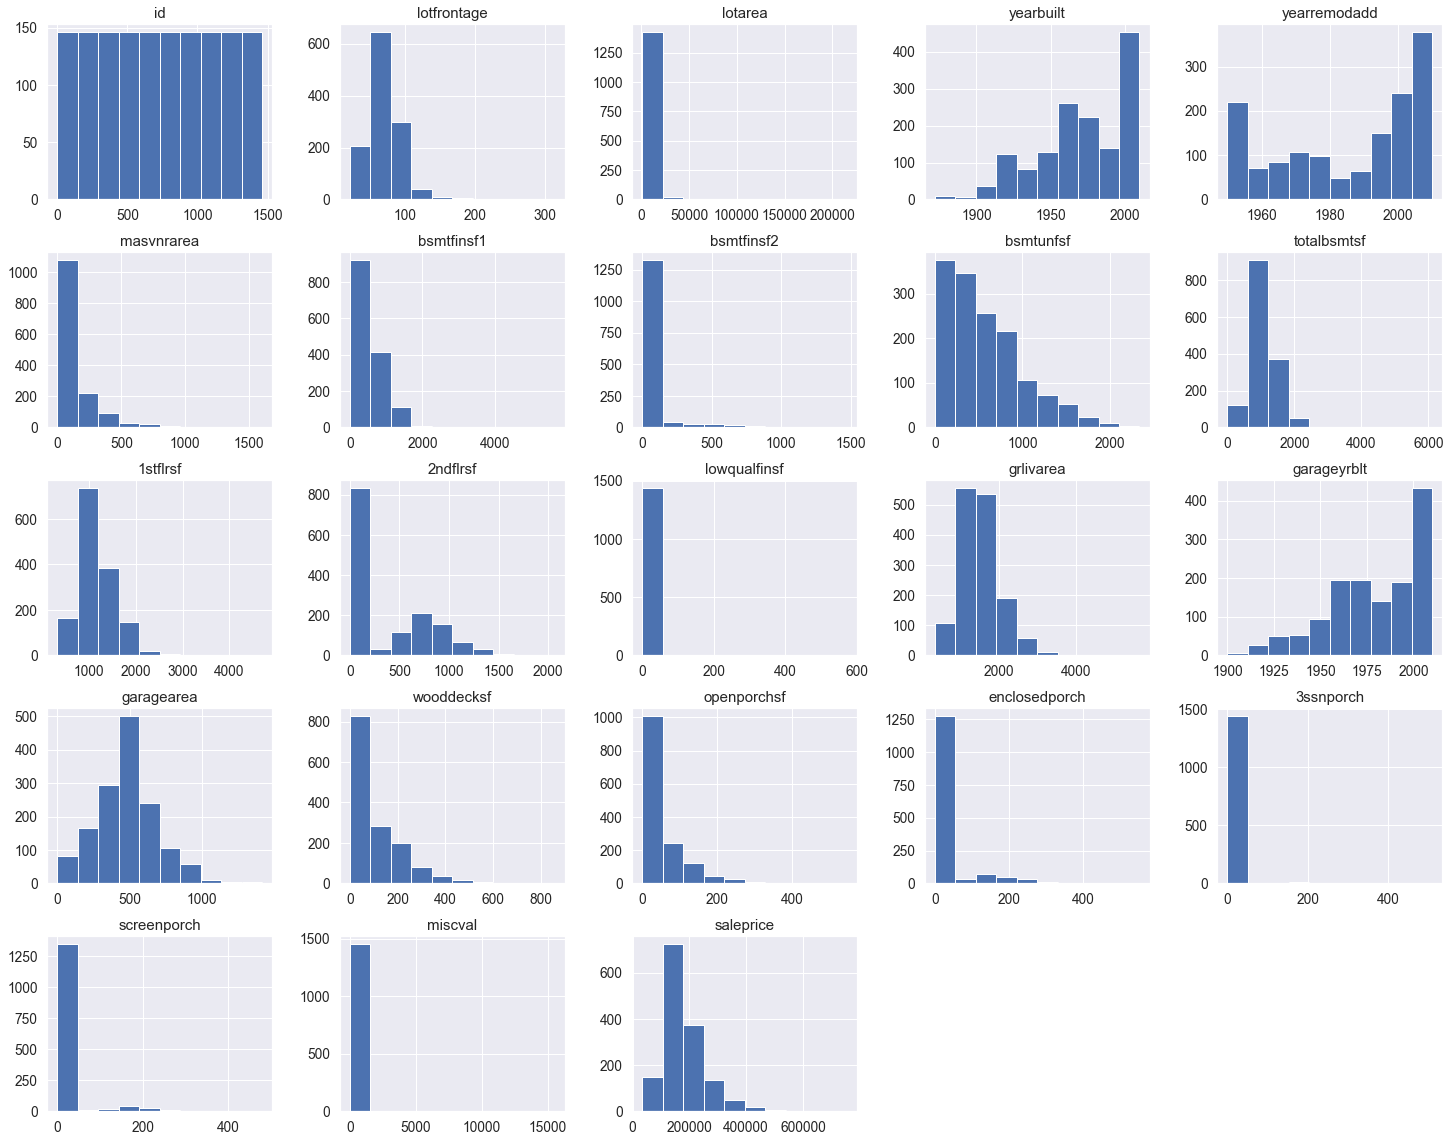

In [208]:
df[num_cols].hist(figsize=(25,20))
plt.show

### 1.2. Transform data that has missing values

To transform data that have missing values, we follow the following criteria:
* Columns with most null values: replace with none, since they are nested variables
* Columns with dominant values: replace it with none
* Columns with missing values: if they are not most null, with replace them with median values (if they are numerical) or mode (if they are categorical).

In [209]:
most_null = []
for i in df.columns:
    null = df[df[i].isnull()]
    if len(null) > 0.3*len(df.index):
        most_null.append(i)
print(most_null)

['alley', 'fireplacequ', 'poolqc', 'fence', 'miscfeature']


In [210]:
df[most_null] = df[most_null].fillna("None")
df[most_null].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   alley        1460 non-null   object
 1   fireplacequ  1460 non-null   object
 2   poolqc       1460 non-null   object
 3   fence        1460 non-null   object
 4   miscfeature  1460 non-null   object
dtypes: object(5)
memory usage: 57.2+ KB


In [211]:
#Replace with none

for col in ('garagetype', 'garagefinish', 'garagequal', 'garagecond'):
        df[col] = df[col].fillna('None')

for col in ('garageyrblt', 'garagearea', 'garagecars'):
        df[col]= df[col].fillna(0)
for col in ('bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf','totalbsmtsf', 'bsmtfullbath', 'bsmthalfbath'):
    df[col] = df[col].fillna(0)

for col in ('bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2'):
    df[col] = df[col].fillna('None')


#Replace missing data with median or mode

df["lotfrontage"] = df.groupby("neighborhood")["lotfrontage"].transform(lambda x: x.fillna(x.median()))

df['mszoning'] = df['mszoning'].fillna(df['mszoning'].mode()[0])
df['electrical'] = df['electrical'].fillna(df['electrical'].mode()[0])
df['kitchenqual'] = df['kitchenqual'].fillna(df['kitchenqual'].mode()[0])
df["functional"] = df["functional"].fillna("typ")
df["masvnrtype"] = df["masvnrtype"].fillna(df["masvnrtype"].mode()[0])
df["masvnrarea"] = df["masvnrarea"].fillna(df["masvnrarea"].mode()[0])




We check if there are any missing values remaining

In [212]:
df.isnull().values.any()

False

### 1.3. Transform data that has the incorrect data type

Type of dwelling is encoded as a numerical data type and needs to be transformed into string type.
Since year and month sold falls into the categorical data criteria, they are also transformed into string type.

In [213]:
#Year sold, month sold  and type of dweling re transformed into categorical features.
df['mssubclass'] = df['mssubclass'].astype(str)
df['yrsold'] = df['yrsold'].astype(str)
df['mosold'] = df['mosold'].astype(str)

print(f"Categorical Variables={cat_cols}")

Categorical Variables=['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition', 'mssubclass', 'overallqual', 'overallcond', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'poolarea', 'mosold', 'yrsold']


### 1.4. Remove variables that are almost constant

In [214]:
#remove column with almost constant values

#Drop variables
df = df.drop(['utilities'], axis=1)

cat_cols.remove('utilities')
print(f"Categorical Variables={cat_cols}")

Categorical Variables=['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'lotconfig', 'landslope', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition', 'mssubclass', 'overallqual', 'overallcond', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'poolarea', 'mosold', 'yrsold']


### 1.5. Create a new target variable "price per square feet"

After transforming and creating the new target variable, we can export the transformed data for other usages.

In [215]:
#creating variable price per sqft
df['price_per_sqft'] = df['saleprice']/ df['grlivarea']

df.to_csv('transformed.csv')

print(f"All columns={df.columns}")

All columns=Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'lotconfig', 'landslope',
       'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle',
       'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc',
       'centralair', 'electrical', '1stflrsf', '2ndflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd',
       'functional', 'fireplaces', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond',
       'paveddrive'

## 2. Exploratory analysis

### 2.1. Selecting relevant variables

Variables related to the size of the houses are removed.

In [216]:
to_remove= ['saleprice', '1stflrsf', '2ndflrsf', 'grlivarea', 'id', 'neighborhood']
df_clean = df.drop(to_remove, axis=1)

for i in to_remove:
    if i in num_cols:
        num_cols.remove(i)
print(f"All columns={df_clean.columns}")
print

All columns=Index(['mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street', 'alley',
       'lotshape', 'landcontour', 'lotconfig', 'landslope', 'condition1',
       'condition2', 'bldgtype', 'housestyle', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'masvnrarea', 'exterqual', 'extercond',
       'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1',
       'bsmtfinsf1', 'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf',
       'heating', 'heatingqc', 'centralair', 'electrical', 'lowqualfinsf',
       'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
       'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd', 'functional',
       'fireplaces', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond',
       'paveddrive', 'wooddecksf', 'openporchsf', 'enclosedporch', '3ssnporch',
     

<function print>

### 2.2. Analyzing correlations

<AxesSubplot:>

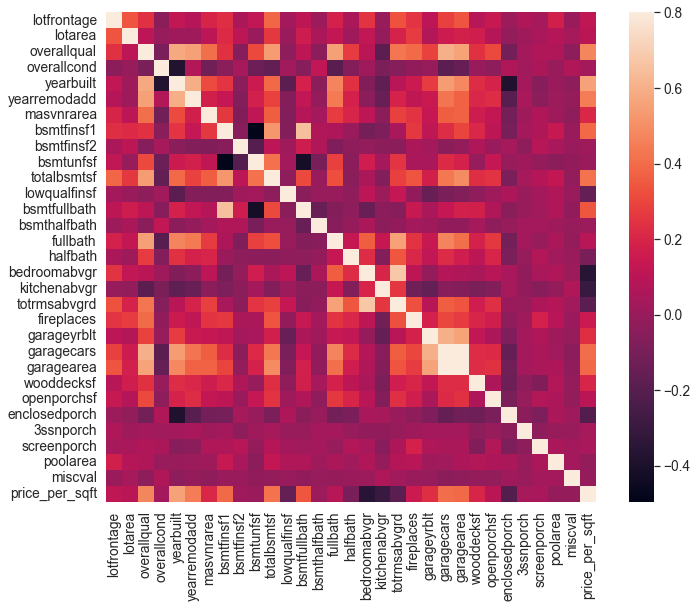

In [217]:
corrmat = df_clean.corr()
f,ax =plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

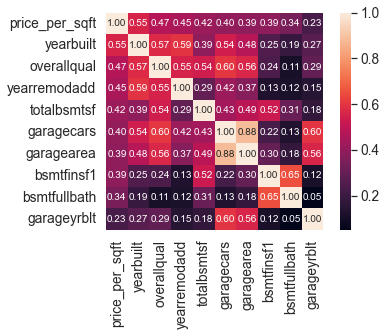

In [218]:
k = 10 #number of variables for heatmap
cols =corrmat.nlargest(k,'price_per_sqft')['price_per_sqft'].index
cm =np.corrcoef(df_clean[cols].values.T)
sns.set(font_scale=1.25)
hm =sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [219]:
corrmat = df_clean.corr()
np.absolute(corrmat['price_per_sqft']).sort_values(ascending=False)

price_per_sqft    1.000000
yearbuilt         0.554921
overallqual       0.473772
yearremodadd      0.448556
totalbsmtsf       0.418392
garagecars        0.401951
garagearea        0.394410
bsmtfinsf1        0.392853
bedroomabvgr      0.355970
bsmtfullbath      0.342586
kitchenabvgr      0.301895
garageyrblt       0.229679
enclosedporch     0.216942
masvnrarea        0.209652
wooddecksf        0.200049
totrmsabvgrd      0.186928
lowqualfinsf      0.159051
fireplaces        0.147418
lotfrontage       0.113601
openporchsf       0.100935
halfbath          0.097079
lotarea           0.096957
fullbath          0.087906
screenporch       0.042951
3ssnporch         0.038848
overallcond       0.031852
bsmtfinsf2        0.016556
poolarea          0.013320
miscval           0.012039
bsmthalfbath      0.010476
bsmtunfsf         0.003849
Name: price_per_sqft, dtype: float64

In [220]:
#delete one of two high correlated features
df_clean = df_clean.drop(['garagearea'], axis=1)
df_clean.to_csv('visualizations.csv', index=False)
df_clean.shape

(1460, 74)

In [221]:
#creating a low correlation group
corr = np.absolute(corrmat['price_per_sqft'])
low_corr=corr.index[corr<0.3].tolist()
df_clean.drop(low_corr, axis=1)

#eliminating a low correlation group
for i in low_corr:
   if i in cat_cols:
       cat_cols.remove(i)

df_clean.shape

(1460, 74)

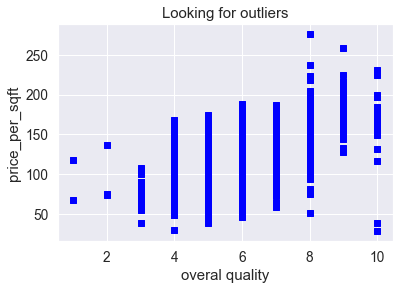

In [222]:
plt.scatter(df_clean.overallqual, df_clean.price_per_sqft, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("overal quality")
plt.ylabel('price_per_sqft')
plt.show()

In [223]:
df_clean = df_clean[(df_clean['overallqual']!='10') & (df_clean['price_per_sqft']>50)]
df_clean.shape

(1449, 74)

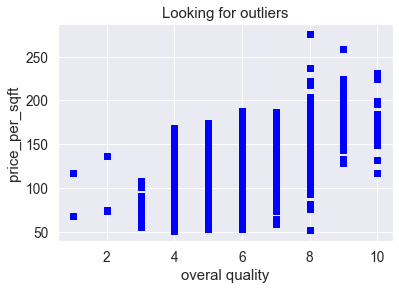

In [224]:
plt.scatter(df_clean.overallqual, df_clean.price_per_sqft, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("overal quality")
plt.ylabel('price_per_sqft')
plt.show()

## 3. Data Modeling and Predictions

### 3.1. Making lables for classes

In [225]:
def encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df_clean = encoder(df_clean,cat_cols,drop_first=True)
df_clean.shape

(1449, 277)

### 3.2. Spliting dataset into train and test sets

In [226]:
y = df_clean['price_per_sqft']
X = df_clean.drop(['price_per_sqft'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1086, 276) (363, 276)
(1086,) (363,)


### 3.3. Normalizing the data

The data is normalized using the following criteria:
* Target Value = log-normalization
* Features = standardization

C:\Users\hmari\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 119.21 and sigma = 28.20



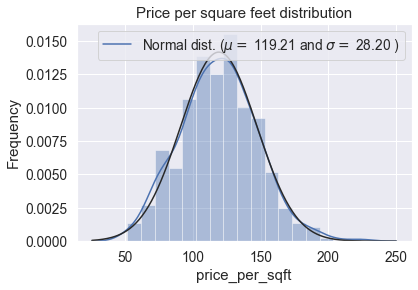

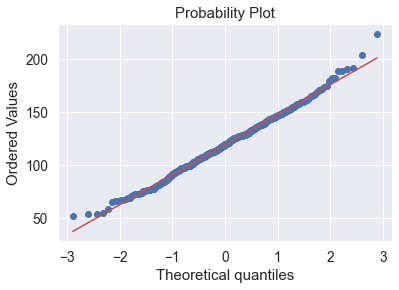

In [227]:
sns.distplot(y_test , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_test)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price per square feet distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_test, plot=plt)
plt.show()

C:\Users\hmari\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 4.78 and sigma = 0.26



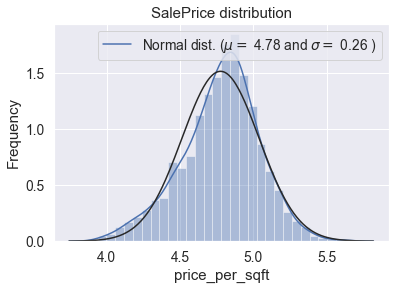

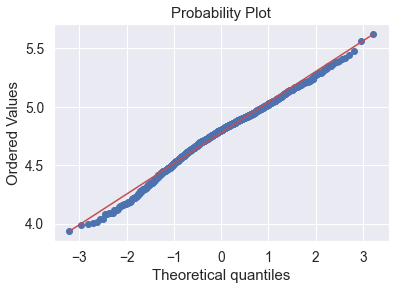

In [228]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

#Check the new distribution 
sns.distplot(y_train , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

### 3.4. Creating and applying a regression model

In [229]:
regr = LinearRegression() #create a regression object
regr.fit(X_train, y_train) #train the model

LinearRegression()

In [230]:
from sklearn.metrics import mean_squared_error, r2_score
y_test_pred = regr.predict(X_test) #make prediction
y_train_pred = regr.predict(X_train)
# The coefficients
#print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error test: %.2f" % mean_squared_error(y_test, y_test_pred))
print("Mean squared error train: %.2f" % mean_squared_error(y_train, y_train_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination test: %.2f" % r2_score(y_test, y_test_pred))
print("Coefficient of determination train: %.2f" % r2_score(y_train, y_train_pred))

Mean squared error test: 0.02
Mean squared error train: 0.01
Coefficient of determination test: 0.67
Coefficient of determination train: 0.86


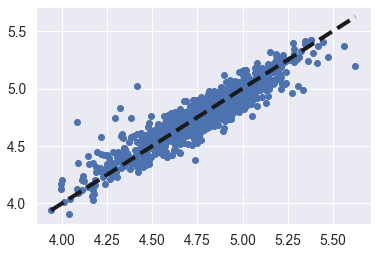

In [231]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_train, y_train_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "k--", lw=4)
plt.show()

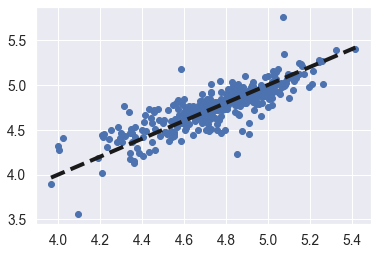

In [232]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_test_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
plt.show()

In [233]:
for x, y in zip(regr.feature_names_in_, regr.coef_):
    print( x,y)

lotfrontage 0.00021382413417663464
lotarea 3.192950100993747e-06
overallcond 0.04527501351184274
yearbuilt 0.0033324473491521695
yearremodadd -0.00016099526363852931
masvnrarea 2.6784658249092352e-05
bsmtfinsf1 9.330228397339663e-06
bsmtfinsf2 2.1806335171280298e-05
bsmtunfsf -6.634435073452224e-05
totalbsmtsf -3.520779191238071e-05
lowqualfinsf -8.858312032907628e-05
bsmthalfbath 0.005953200834237043
fullbath -0.034327158646344176
halfbath -0.022375250646612454
totrmsabvgrd -0.02565259944323829
fireplaces 0.013168036321350853
garageyrblt -0.00010235414495385602
wooddecksf 4.977158059986386e-05
openporchsf 0.00010697910356033402
enclosedporch 9.773337605730988e-05
3ssnporch 0.000158834493584923
screenporch 0.00019181410458254597
poolarea -0.00012091408467761883
miscval 7.391740870157232e-05
mszoning_FV 0.27922277895348574
mszoning_RH 0.20560962767805369
mszoning_RL 0.2267167561903222
mszoning_RM 0.16369646484448708
street_Pave 0.14598175740537084
alley_None 0.008121653879609461
alley_P

### 3.5. Creating cross validation scores for several models using mean square errors

In [234]:
#create models

models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("LightGBM", LGBMRegressor())]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 0.1519 (LR) 
RMSE: 0.1327 (Ridge) 
RMSE: 0.2007 (Lasso) 
RMSE: 0.195 (ElasticNet) 
RMSE: 0.2349 (KNN) 
RMSE: 0.2152 (CART) 
RMSE: 0.1425 (RF) 
RMSE: 0.2222 (SVR) 
RMSE: 0.138 (GBM) 
RMSE: 0.138 (LightGBM) 


In [235]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("LightGBM", LGBMRegressor())]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X_test, y_test, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 0.262 (LR) 
RMSE: 0.1556 (Ridge) 
RMSE: 0.213 (Lasso) 
RMSE: 0.215 (ElasticNet) 
RMSE: 0.2276 (KNN) 
RMSE: 0.2135 (CART) 
RMSE: 0.1535 (RF) 
RMSE: 0.2244 (SVR) 
RMSE: 0.1387 (GBM) 
RMSE: 0.1548 (LightGBM) 


### 3.5. Creating and export prediction values



In [236]:
GBM = GradientBoostingRegressor()
RF = RandomForestRegressor()
LGBM = LGBMRegressor()
GBM.fit(X_train, y_train)
RF.fit(X_train, y_train)
LGBM.fit(X_train, y_train)
y_test_pred_GBM = GBM.predict(X_test) #make prediction
y_train_pred_GBM = GBM.predict(X_train)
y_test_pred_RF = GBM.predict(X_test) #make prediction
y_train_pred_RF = RF.predict(X_train)
y_test_pred_LGBM = LGBM.predict(X_test) #make prediction
y_train_pred_LGBM = LGBM.predict(X_train)

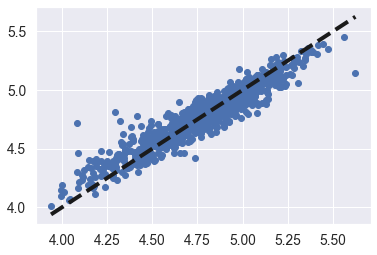

In [237]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_train_pred_GBM)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "k--", lw=4)
plt.show()

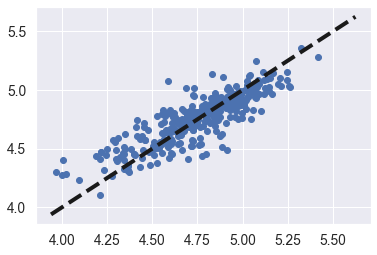

In [238]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_test_pred_GBM)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "k--", lw=4)
plt.show()

In [239]:
y_test_pred_GBM = np.expm1(y_test_pred_GBM)
y_train_pred_GBM = np.expm1(y_train_pred_GBM)
y_test_pred_RF = np.expm1(y_test_pred_RF)
y_train_pred_RF = np.expm1(y_train_pred_RF)
y_test_pred_LGBM = np.expm1(y_test_pred_LGBM)
y_train_pred_LGBM = np.expm1(y_train_pred_LGBM)



In [240]:
y_pred_GBM = np.expm1(GBM.predict(X))
y_pred_RF = np.expm1(RF.predict(X))
y_pred_LGBM = np.expm1(LGBM.predict(X))
d = {'PriceGBM': y_pred_GBM, 'PriceRF':y_pred_RF, 'PriceLGBM':y_pred_LGBM}
df_pred = pd.DataFrame(d)
df_pred.to_csv('Predictions.csv')